In [17]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special



def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

# rr = np.arange(12, 19, 1)
# ee = np.arange(0,725,25)
# em = np.arange(25,725,25)
# em = np.append(1,em)
# random_v = np.arange(250,7250,250)
# random_v = np.append(118,random_v)


directory_1 = '/home/jin/data_jin/'
rr = np.arange(12, 17, 1)
atom_N = [13, 20, 32, 50, 79]
rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom_N / 10
total_N_c = total_N_c.flatten()

emit = np.arange(1000,6000,1000)
emit = np.append(1,emit)

expand_vel = np.arange(0,6000,1000)

random_vel = np.arange(1000,6000,1000)
random_vel= np.append(118,random_vel)

# atom = [13,20,32,50,79]

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952



NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-10,10, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)



def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak



def gauss_func(F_c,x,x_0,sig):
    xx = np.linspace(x.min(),x.max(),1000)
    ss = (xx-x_0)/sig
    ex = np.zeros(len(xx))
    ex = F_c*np.exp(-ss**2/2)
    return  xx,ex

# plt.plot(del_V_space_g,yy_g)

3.39090e+13


In [18]:

def analy_function(sigma):
    NN = 10000  
    xx = np.linspace(1530,1570,NN)
    sp_dlam_1 = xx
    tv_k = ((xx-C_IV_K_A ) / C_IV_K_A ) * cc_k
    tv_h = ((xx-C_IV_H_A) / C_IV_H_A ) * cc_k
    tk = (tv_k)**2 / sigma**2
    th = (tv_h)**2 / sigma**2
    fx = (1 / np.sqrt(2*np.pi*sigma**2))  *(2*np.exp(-tk/2) + np.exp(-th/2) )
    f0 = fx[np.argmax(fx)]
    sp_1 = fx
    del_V_space = (sp_dlam_1 / C_IV_K  - 1) * cc_k

    lam_c= ((C_IV_H_A + C_IV_K_A)/2)

    
    indices_K_V = np.where(xx <= lam_c)[0]
    indices_H_V = np.where(xx >=lam_c)[0]

    sp_V_K = del_V_space[indices_K_V]
    sp_V_H = del_V_space[indices_H_V]

    sp_K_f = sp_1[indices_K_V]
    sp_H_f = sp_1[indices_H_V] 

    sp_lam_K = sp_dlam_1[indices_K_V]
    sp_lam_H = sp_dlam_1[indices_H_V]

    dk = sp_lam_K[1]-sp_lam_K[0]  
    int_k = np.sum(dk*sp_K_f,axis=0)
    dh = sp_lam_H[1]-sp_lam_H[0]  
    int_h = np.sum(dh*sp_H_f,axis=0)
    RC = int_k/ int_h
    # print(len(fx/f0))
    return RC , fx/f0

In [19]:
emit = 100
v_ran = 118
check = 0
for ii, index in enumerate(rr):
    for jj, expand in enumerate(expand_vel):
        if expand ==0:
            expand_v = '000'
            num_e = 0
        elif abs(expand) >= 1000:
            expand_v = int(expand / 10) 
            num_e = 2
        else :
            expand_v = expand 
            num_e = 1
        for kk,atom_n in enumerate(atom_N):
            path_sp= f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}E+0{num_e}_Vemit{emit}E+02_tauD000E+00_Vran118E+01spec_com.dat'
        # 데이터 읽기
            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][0]
            globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][2]

            # K and H line seperate
            lam_c = (C_IV_K_A+C_IV_H_A)/2
            #K line
            globals()[f'halo_x_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= lam_c]
            globals()[f'halo_y_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= lam_c]
            #H line
            globals()[f'halo_x_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= lam_c]
            globals()[f'halo_y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= lam_c]

         


            globals()[f'halo_vx_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = ((globals()[f'halo_x_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] - C_IV_K_A) /  C_IV_K_A)*cc_k
            globals()[f'halo_vy_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}']=  globals()[f'halo_y_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}']



            globals()[f'halo_vx_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = ((globals()[f'halo_x_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] - C_IV_K_A) /  C_IV_K_A)*cc_k
            globals()[f'halo_vy_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']=  globals()[f'halo_y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']
    
print(check)

0


In [20]:
emit = 100
v_ran = 118
check= 0
for ii, index in enumerate(rr):
    for jj, expand in enumerate(expand_vel):
        if expand ==0:
            expand_v = '000'
            num_e = 0
        elif abs(expand) >= 1000:
            expand_v = int(expand / 10) 
            num_e = 2
        else :
            expand_v = expand 
            num_e = 1
        for kk,atom_n in enumerate(atom_N):
            path_sp= f'{directory_1}N_atom{atom_n}0E+{index}_Vexp{expand_v}E+0{num_e}_Vemit{emit}E+02_tauD000E+00_Vran118E+01spec_com.dat'
        # 데이터 읽기
            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][0]
            globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'data_sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'][1]

            # K and H line seperate
            lam_c = (C_IV_K_A+C_IV_H_A)/2
            #K line
            globals()[f'tot_x_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= lam_c]
            globals()[f'tot_y_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] <= lam_c]
            #H line
            globals()[f'tot_x_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= lam_c]
            globals()[f'tot_y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = globals()[f'sp_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] [globals()[f'sp_dlam_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] >= lam_c]

         


            globals()[f'tot_vx_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = ((globals()[f'tot_x_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] - C_IV_K_A) /  C_IV_K_A)*cc_k
            globals()[f'tot_vy_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}']=  globals()[f'tot_y_K_{atom_n}_{index}_{expand}_{emit}_{v_ran}']



            globals()[f'tot_vx_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] = ((globals()[f'tot_x_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}'] - C_IV_K_A) /  C_IV_K_A)*cc_k
            globals()[f'tot_vy_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']=  globals()[f'tot_y_H_{atom_n}_{index}_{expand}_{emit}_{v_ran}']

print(check)

0


Text(770, 0.6, '$\\rm V_{\\rm exp} = 400\\,\\rm km\\,s^{-1}$')

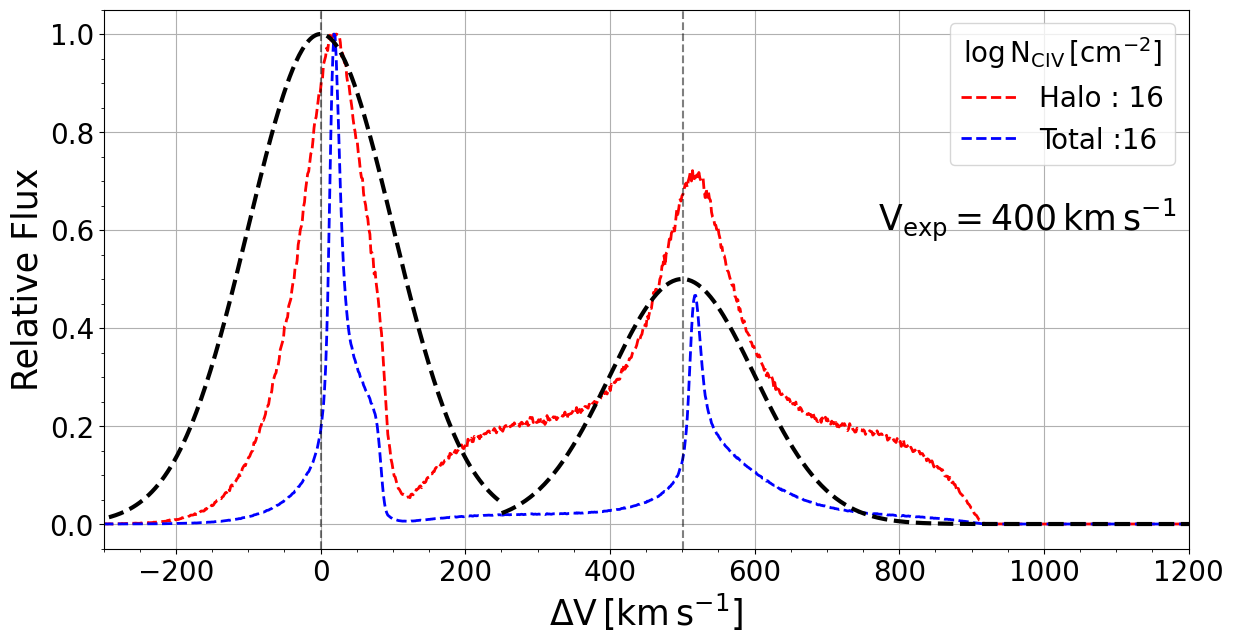

In [43]:
fig = plt.figure(1,figsize=(14,7))



atom_n = 32
index = 14

dnu = (C_IV_H/C_IV_K - 1)*cc_k

v_ran = 118
emit_n = 100


expand = 4000


index= 13
# normal_f =  max(globals()[f'halo_vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'])
# # normal_f = 1
# plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] / normal_f ,'r--',lw=2,label=f'Halo : {index}')
# plt.plot(globals()[f'halo_vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'halo_vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] / normal_f ,'r--',lw=2)

atom_n = 32
index = 16
expand = 4000
v_ran = 118
# emit_n = 50


normal_f =  max(globals()[f'halo_vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'])
# normal_f = 1
plt.plot(globals()[f'halo_vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'halo_vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] / normal_f ,'r--',lw=2,label=f'Halo : {index}')
plt.plot(globals()[f'halo_vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'halo_vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] / normal_f ,'r--',lw=2)

normal_f =  max(globals()[f'tot_vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'])
plt.plot(globals()[f'tot_vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'tot_vy_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] / normal_f ,'b--',lw=2,label=f'Total :{index}')
plt.plot(globals()[f'tot_vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],globals()[f'tot_vy_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'] / normal_f ,'b--',lw=2)



atom_n = 32
index = 14
v_ran = 118
emit_n = 100


expand = 0

xx_k,int_gau_K= gauss_func(normal_f,globals()[f'halo_vx_K_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],0,100)
xx_h,int_gau_H= gauss_func(normal_f,globals()[f'halo_vx_H_{atom_n}_{index}_{expand}_{emit_n}_{v_ran}'],500,100)



plt.plot(xx_k,int_gau_K/normal_f,'k--',lw=3)
plt.plot(xx_h,int_gau_H/normal_f/2,'k--',lw=3)

plt.xlim(-300, 1200)
plt.minorticks_on()
plt.grid(True)
plt.legend(loc='upper right',fontsize=20,ncol=1,title=r'$\log{{\rm N}_{\rm C IV}}\,[\rm cm ^{-2}]$',title_fontsize=20)
plt.xlabel(r'$\Delta \rm V \, [\rm km\,s^{-1}]$',fontsize=25)
plt.ylabel(r'Relative Flux',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axvline(x=0,ymin=0,ymax=5,color='k',linestyle='--',alpha=0.5)
plt.axvline(x=dnu,ymin=0,ymax=5,color='k',linestyle='--',alpha=0.5)
ymin = -0.1
ymax = 1
expand = 4000
plt.text(770, ymax*(0.6), f'$\\rm V_{{\\rm exp}} = {int(expand/10)}\\,\\rm km\\,s^{{-1}}$', size=25, fontweight='bold')

# plt.ylim(ymin,ymax)
#400 -> 2.1
#500 -> 0.97

# plt.savefig(f'/home/jin/바탕화면/DelV_gauss_source_density_{expand}km.pdf',bbox_inches='tight')

NameError: name 'vx_K_32_14_0_100_118' is not defined

In [22]:
halo_vx_K_32_16_

1499     250.280975
1500     251.733282
1501     253.204954
1502     254.657261
1503     256.109569
           ...     
2995    2431.143222
2996    2432.595529
2997    2434.047836
2998    2435.519508
2999    2436.971815
Name: 0, Length: 1501, dtype: float64